In [1]:
import os
import sys

NJET_BLHA='/Users/simon/packages/njet-3.1.1-1L/blha/'
sys.path.append(NJET_BLHA)

import numpy as np
from pstools.rambo import generate, dot
from njettools.njet_interface import *
from nntools.model_errorensemble import Model_ErrorEnsemble

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
contract_file = 'NJ_contract_ee3j_tree.lh'

In [3]:
# generate 2 -> 3 phase-space points for training
n_training_points = 1000
delta_cut = 0.02

momenta, n_trials = generate(3, n_training_points, rts=1000., delta=delta_cut)
momenta = momenta.tolist()

100%|██████████| 1000/1000 [00:00<00:00, 5743.73it/s]


In [4]:
olp = njet.OLP()

In [5]:
status = njet_init(contract_file)

if status == True:
    print ("OLP read in correctly")
else:
    print ("seems to be a problem with the contract file...")

OLP read in correctly


In [6]:
mur = 100.
alphas = 0.118
alpha = 1/137.

In [7]:
NJ_treevals = [];
for pt in range(n_training_points):
    vals = olp.OLP_EvalSubProcess(1,
                                  momenta[pt],
                                  alphas=alphas,
                                  alpha=alpha,
                                  mur=mur,
                                  retlen=1)
    
    NJ_treevals.append(vals[0])

In [8]:
# dump generated data in case NJet and interface not available
np.save("data/NJens_ee3j_tree_momenta.npy", momenta)
np.save("data/NJens_ee3j_tree_values.npy", NJ_treevals)

In [9]:
momenta = np.load("data/NJens_ee3j_tree_momenta.npy")
NJ_treevals = np.load("data/NJens_ee3j_tree_values.npy")

In [10]:
NN = Model_ErrorEnsemble(
    5*4, # number of input variables for n-particle amplitude
    momenta[:n_training_points], # input data from Rambo PS generator
    np.array(NJ_treevals) # data points from NJet evaluations
)

In [11]:
modelensemble = []
for ii in range(10):
    print("training model",ii)
    model, x_mean, x_std, y_mean, y_std = NN.fit(layers=[16,32,16])
    modelensemble.append([model, x_mean, x_std, y_mean, y_std])

training model 0
The training dataset has size (800, 20)
Epoch 1/10000
800/800 [==============================] - 1s 901us/sample - loss: 1.7262 - val_loss: 0.7891
training model 1
The training dataset has size (800, 20)
Epoch 1/10000
800/800 [==============================] - 1s 963us/sample - loss: 0.9533 - val_loss: 1.9577
Epoch 1001/10000
800/800 [==============================] - 0s 13us/sample - loss: 0.0055 - val_loss: 0.3376
training model 2
The training dataset has size (800, 20)
Epoch 1/10000
800/800 [==============================] - 1s 941us/sample - loss: 1.6186 - val_loss: 0.5367
training model 3
The training dataset has size (800, 20)
Epoch 1/10000
800/800 [==============================] - 1s 852us/sample - loss: 0.7336 - val_loss: 2.5056
training model 4
The training dataset has size (800, 20)
Epoch 1/10000
800/800 [==============================] - 1s 887us/sample - loss: 1.3327 - val_loss: 1.6852
training model 5
The training dataset has size (800, 20)
Epoch 1/10000


In [12]:
n_points = 1000
newmomenta, n_trials2 = generate(3, n_points, rts=1000., delta=delta_cut)
newmomenta = newmomenta.tolist()

100%|██████████| 1000/1000 [00:00<00:00, 3714.35it/s]


In [13]:
NJ_treevals_test = [];
for pt in range(n_points):
    vals = olp.OLP_EvalSubProcess(1, 
                                  newmomenta[pt],
                                  alphas=alphas,
                                  alpha=alpha,
                                  mur=mur,
                                  retlen=1)
    
    NJ_treevals_test.append(vals[0])

In [14]:
modelensemble[0][4]

0.1590499272524583

In [15]:
amp_preds = []
for ii in range(len(modelensemble)):
    x_standardized = NN.process_testing_data(moms=newmomenta,
                                 x_mean=modelensemble[ii][1],
                                 x_std=modelensemble[ii][2],
                                 y_mean=modelensemble[ii][3],
                                 y_std=modelensemble[ii][4])
    
    mpred = modelensemble[ii][0].predict(x_standardized)
    
    amp_preds.append(NN.destandardise_data(mpred.reshape(-1),
                                 x_mean=modelensemble[ii][1],
                                 x_std=modelensemble[ii][2],
                                 y_mean=modelensemble[ii][3],
                                 y_std=modelensemble[ii][4]))
    
amp_preds = np.transpose(np.array(amp_preds))

In [16]:
amp_pred = []
for ii in range(n_points):
    amp_pred.append([np.mean(amp_preds[ii]),np.std(amp_preds[ii])])
amp_pred = np.array(amp_pred)

In [17]:
diff = (amp_pred[:,0]-np.array(NJ_treevals_test))/(amp_pred[:,0]+np.array(NJ_treevals_test))

In [18]:
print(amp_pred[0,0], NJ_treevals_test[0], amp_pred[0,1], diff[0])
print(amp_pred[1,0], NJ_treevals_test[1], amp_pred[1,1], diff[1])

0.019915998 0.013919130753093594 0.011238177 0.17723790194145705
0.044491015 0.06991304940787799 0.026707757 -0.22221268170444994


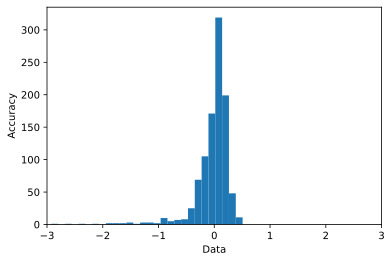

In [19]:
plt.hist(diff, density=False, bins=100)
plt.xlim([-3,3])
plt.ylabel('Accuracy')
plt.xlabel('Data');

In [20]:
logdiff = np.log10(abs(diff))

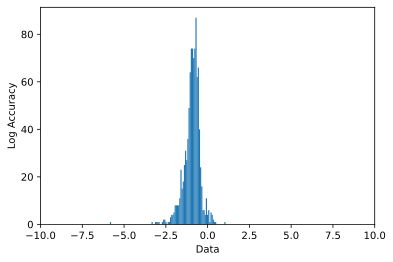

In [21]:
plt.hist(logdiff, density=False, bins=100)
plt.xlim([-10,10])
plt.ylabel('Log Accuracy')
plt.xlabel('Data');